#**Import Libraries and Download Data**

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error
import math
from warnings import simplefilter
from hyperopt import fmin, tpe, hp, space_eval, Trials
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go




In [2]:
data = pd.read_csv('/content/XLM-USD.csv',index_col='Date', parse_dates=['Date'])
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,0.033792,0.040380,0.033744,0.039946,0.039946,32813200
2017-11-10,0.039833,0.039833,0.031366,0.033073,0.033073,32634200
2017-11-11,0.033083,0.035829,0.031881,0.033053,0.033053,17914400
2017-11-12,0.032965,0.033334,0.027469,0.028182,0.028182,17002300
2017-11-13,0.028115,0.031968,0.028041,0.030656,0.030656,11245700
...,...,...,...,...,...,...
2021-12-27,0.291515,0.305289,0.291262,0.298911,0.298911,322738218
2021-12-28,0.298614,0.298655,0.273845,0.274574,0.274574,462409941
2021-12-29,0.274443,0.279392,0.265657,0.266442,0.266442,373052601


In [3]:
print(data.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [4]:
print(data.shape)

(1514, 6)


In [5]:
data.iloc[:, 2:-1].describe()

,Low,Close,Adj Close
count,1514.000000,1514.000000,1514.000000
mean,0.191235,0.201877,0.201877
std,0.136562,0.147406,0.147406
min,0.027469,0.028182,0.028182
25%,0.075756,0.077965,0.077965
50%,0.132019,0.140222,0.140222
75%,0.281473,0.297386,0.297386
max,0.677496,0.896227,0.896227


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1514 entries, 2017-11-09 to 2021-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1514 non-null   float64
 1   High       1514 non-null   float64
 2   Low        1514 non-null   float64
 3   Close      1514 non-null   float64
 4   Adj Close  1514 non-null   float64
 5   Volume     1514 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 82.8 KB


In [7]:
#Normalisasi Data : Min-Max Scaler

close_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

In [8]:
# Extract original and scaled close prices
original_close_prices = data['Close'].values
scaled_close_prices = scaled_data.flatten()

# Calculate statistics
original_stats = pd.Series(original_close_prices).describe()
scaled_stats = pd.Series(scaled_close_prices).describe()

# Print the summary
print("Original Close Prices Statistics:")
print(original_stats)

print("\nScaled Close Prices Statistics:")
print(scaled_stats)


Original Close Prices Statistics:
count    1514.000000
mean        0.201877
std         0.147406
min         0.028182
25%         0.077965
50%         0.140222
75%         0.297386
max         0.896227
dtype: float64

Scaled Close Prices Statistics:
count    1514.000000
mean        0.200099
std         0.169814
min         0.000000
25%         0.057350
50%         0.129072
75%         0.310126
max         1.000000
dtype: float64


In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Plot all prices
fig = go.Figure()

fig.add_trace(go.Scatter(x=data.index, y=data['Open'], mode='lines', name='Opening Price', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='Closing Price', line=dict(color='black')))
fig.add_trace(go.Scatter(x=data.index, y=data['Low'], mode='lines', name='Low Price', line=dict(color='red')))
fig.add_trace(go.Scatter(x=data.index, y=data['High'], mode='lines', name='High Price', line=dict(color='green')))

fig.update_layout(
    title='Stock Price History Stellar (XLM)',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Stock Price'),
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
)

# Plot subplots for each individual price
fig_subplots = make_subplots(rows=2, cols=2, subplot_titles=('Opening Price', 'Closing Price', 'Low Price', 'High Price'))

fig_subplots.add_trace(go.Scatter(x=data.index, y=data['Open'], mode='lines', name='Opening Price', line=dict(color='blue')), row=1, col=1)
fig_subplots.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='Closing Price', line=dict(color='black')), row=1, col=2)
fig_subplots.add_trace(go.Scatter(x=data.index, y=data['Low'], mode='lines', name='Low Price', line=dict(color='red')), row=2, col=1)
fig_subplots.add_trace(go.Scatter(x=data.index, y=data['High'], mode='lines', name='High Price', line=dict(color='green')), row=2, col=2)

fig_subplots.update_layout(title='Stock Price Stellar (XLM)', showlegend=False)

fig.show()
fig_subplots.show()

#**Data Preprocessing and Preparation**

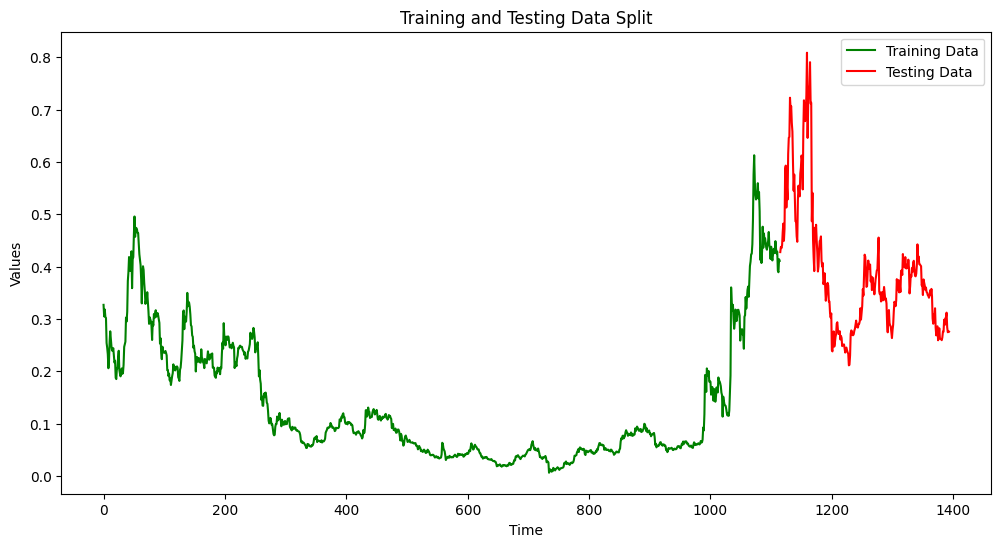

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from hyperopt import fmin, tpe, Trials, space_eval
from sklearn.metrics import mean_squared_error

# Example scaled data for demonstration
# Assume `scaled_data` is your scaled dataset
# scaled_data = ...

# Data preparation function
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        lag_values = data[i:(i + n_steps), 0]
        X.append(lag_values)
        y.append(data[i + n_steps, 0])
    return np.array(X), np.array(y)

n_steps = 120
X, y = prepare_data(scaled_data, n_steps)

# Splitting into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM and GRU models
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_train_gru = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_gru = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Function to plot the training and testing dataset split
def plot_dataset_split(X_train, X_test, y_train, y_test):
    plt.figure(figsize=(12, 6))

    time_train = np.arange(len(X_train))
    time_test = np.arange(len(X_train), len(X_train) + len(X_test))

    plt.plot(time_train, y_train, label='Training Data', color='green')
    plt.plot(time_test, y_test, label='Testing Data', color='red')

    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Training and Testing Data Split')
    plt.legend()
    plt.show()

# Plot the dataset split for LSTM and GRU
plot_dataset_split(X_train_lstm, X_test_lstm, y_train, y_test)


#**Hyperparameter Tuning**

In [11]:
# Define hyperparameter search space
space = {
    'units': hp.choice('units', [50, 100, 150]),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning rate', np.log(0.001), np.log(0.01)),
    'epochs': hp.choice('epochs', [50, 100, 150]),
    'batch_size': hp.choice('batch_size', [32, 64, 128])
}

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


#**Model Building and Training**

In [12]:
# Create a function to build and train the model with hyperparameters
from tensorflow.keras.optimizers import Adamax

def objective(params, model_type, X_train, y_train, X_test, y_test):
    model = Sequential()
    if model_type == 'lstm':
        model.add(LSTM(units=params['units'], return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(params['dropout_rate']))
        model.add(LSTM(units=params['units'], return_sequences=True, activation='tanh'))
        model.add(Dropout(params['dropout_rate']))
        model.add(LSTM(units=params['units'], activation='tanh'))
        model.add(Dense(units=1))
    elif model_type == 'gru':
        model.add(GRU(units=params['units'], return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(params['dropout_rate']))
        model.add(GRU(units=params['units'], return_sequences=True, activation='tanh'))
        model.add(Dropout(params['dropout_rate']))
        model.add(GRU(units=params['units'], activation='tanh'))
        model.add(Dense(units=1))

    model.compile(optimizer=Adamax(learning_rate=params['learning_rate']), loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'],
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_orig, y_pred)
    return mse, history

# Set up the Trials object to keep track of the optimization process
trials_lstm = Trials()
trials_gru = Trials()

# Use the fmin function for Bayesian optimization for LSTM and GRU
best_lstm = fmin(fn=lambda params: objective(params, 'lstm', X_train_lstm, y_train, X_test_lstm, y_test)[0],
                 space=space, algo=tpe.suggest, max_evals=20, trials=trials_lstm)

best_gru = fmin(fn=lambda params: objective(params, 'gru', X_train_gru, y_train, X_test_gru, y_test)[0],
                space=space, algo=tpe.suggest, max_evals=20, trials=trials_gru)

# Get the best hyperparameters from the optimization results
best_params_lstm = space_eval(space, best_lstm)
best_params_gru = space_eval(space, best_gru)


9/9 [==============================] - 1s 11ms/step

9/9 [==============================] - 1s 9ms/step

9/9 [==============================] - 1s 8ms/step

9/9 [==============================] - 1s 8ms/step

9/9 [==============================] - 1s 9ms/step

9/9 [==============================] - 1s 9ms/step

9/9 [==============================] - 1s 15ms/step

9/9 [==============================] - 1s 9ms/step

9/9 [==============================] - 1s 15ms/step

9/9 [==============================] - 1s 8ms/step

9/9 [==============================] - 1s 16ms/step

9/9 [==============================] - 1s 14ms/step

9/9 [==============================] - 1s 12ms/step

9/9 [==============================] - 1s 14ms/step

9/9 [==============================] - 1s 12ms/step

9/9 [==============================] - 1s 8ms/step

9/9 [==============================] - 1s 14ms/step

9/9 [==============================] - 2s 12ms/step

9/9 [==============================] - 2s 17ms/step

9

#**Final Model and History Plot**

In [20]:
# Build the final LSTM model using the best hyperparameters
final_model_lstm = Sequential([
    LSTM(units=best_params_lstm['units'], return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(best_params_lstm['dropout_rate']),
    LSTM(units=best_params_lstm['units'], return_sequences=True),
    Dropout(best_params_lstm['dropout_rate']),
    LSTM(units=best_params_lstm['units']),
    Dense(units=1)
])

final_model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params_lstm['learning_rate']),
                         loss='mean_squared_error')

# Train the final LSTM model
history_lstm = final_model_lstm.fit(X_train_lstm, y_train, epochs=best_params_lstm['epochs'],
                                    batch_size=best_params_lstm['batch_size'], verbose=2,
                                    validation_split=0.1, callbacks=[early_stopping])

# Build the final GRU model using the best hyperparameters
final_model_gru = Sequential([
    GRU(units=best_params_gru['units'], return_sequences=True, input_shape=(X_train_gru.shape[1], 1)),
    Dropout(best_params_gru['dropout_rate']),
    GRU(units=best_params_gru['units'], return_sequences=True),
    Dropout(best_params_gru['dropout_rate']),
    GRU(units=best_params_gru['units']),
    Dense(units=1)
])

final_model_gru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params_gru['learning_rate']),
                        loss='mean_squared_error')

# Train the final GRU model
history_gru = final_model_gru.fit(X_train_gru, y_train, epochs=best_params_gru['epochs'],
                                  batch_size=best_params_gru['batch_size'], verbose=2,
                                  validation_data=(X_test_gru, y_test), callbacks=[early_stopping])


Epoch 1/150
16/16 - 13s - loss: 0.0033 - val_loss: 0.0038 - 13s/epoch - 785ms/step
Epoch 2/150
16/16 - 1s - loss: 7.7449e-04 - val_loss: 0.0036 - 522ms/epoch - 33ms/step
Epoch 3/150
16/16 - 0s - loss: 5.9792e-04 - val_loss: 0.0034 - 313ms/epoch - 20ms/step
Epoch 4/150
16/16 - 0s - loss: 4.5589e-04 - val_loss: 0.0029 - 265ms/epoch - 17ms/step
Epoch 5/150
16/16 - 0s - loss: 4.7566e-04 - val_loss: 0.0025 - 282ms/epoch - 18ms/step
Epoch 6/150
16/16 - 0s - loss: 4.7360e-04 - val_loss: 0.0030 - 267ms/epoch - 17ms/step
Epoch 7/150
16/16 - 0s - loss: 4.4977e-04 - val_loss: 0.0028 - 264ms/epoch - 16ms/step
Epoch 8/150
16/16 - 0s - loss: 4.5855e-04 - val_loss: 0.0026 - 266ms/epoch - 17ms/step
Epoch 9/150
16/16 - 0s - loss: 4.0002e-04 - val_loss: 0.0025 - 278ms/epoch - 17ms/step
Epoch 10/150
16/16 - 0s - loss: 3.5022e-04 - val_loss: 0.0028 - 265ms/epoch - 17ms/step
Epoch 11/150
16/16 - 0s - loss: 3.7975e-04 - val_loss: 0.0030 - 262ms/epoch - 16ms/step
Epoch 12/150
16/16 - 0s - loss: 4.0056e-04 - 

#**Evaluasi Model dan Visualisasi**

9/9 [==============================] - 1s 11ms/step
Performance Metrics for LSTM:
Mean Squared Error (MSE): 0.0008378892747480253
Root Mean Squared Error (RMSE): 0.028946317118901763
Mean Absolute Percentage Error (MAPE): 5.160671229278909
9/9 [==============================] - 1s 11ms/step
Performance Metrics for GRU:
Mean Squared Error (MSE): 0.0007481908439777224
Root Mean Squared Error (RMSE): 0.02735307741329524
Mean Absolute Percentage Error (MAPE): 4.582467485542624


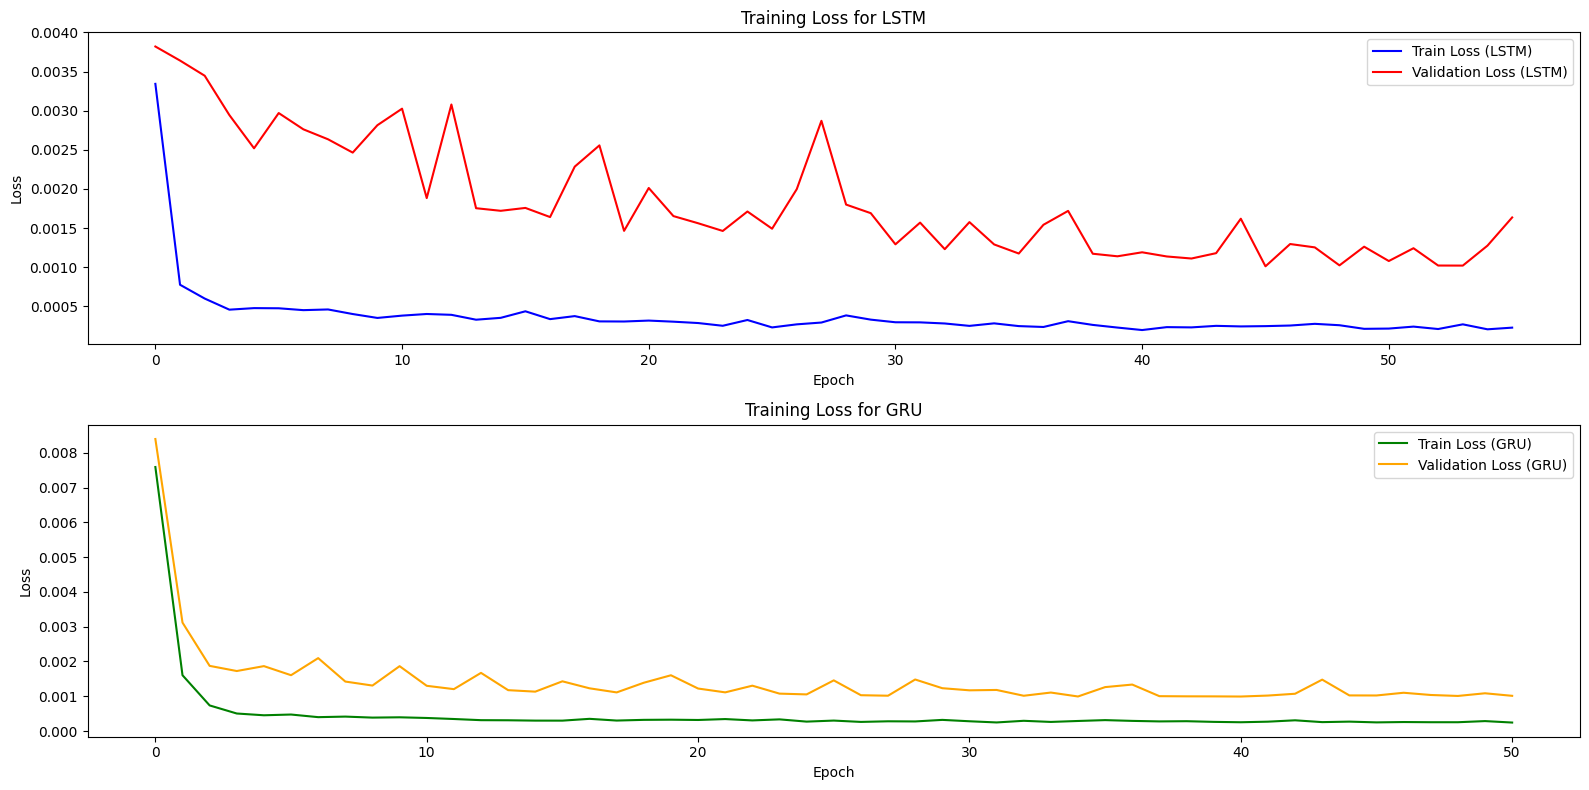

In [21]:
# Model evaluation for LSTM
y_pred_lstm = final_model_lstm.predict(X_test_lstm)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test_orig_lstm = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics for LSTM
mse_lstm = mean_squared_error(y_test_orig_lstm, y_pred_lstm)
rmse_lstm = math.sqrt(mse_lstm)
mape_lstm = np.mean(np.abs((y_test_orig_lstm - y_pred_lstm) / y_test_orig_lstm)) * 100

# Display results for LSTM
print("Performance Metrics for LSTM:")
print("Mean Squared Error (MSE):", mse_lstm)
print("Root Mean Squared Error (RMSE):", rmse_lstm)
print("Mean Absolute Percentage Error (MAPE):", mape_lstm)

# Model evaluation for GRU
y_pred_gru = final_model_gru.predict(X_test_gru)
y_pred_gru = scaler.inverse_transform(y_pred_gru)
y_test_orig_gru = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics for GRU
mse_gru = mean_squared_error(y_test_orig_gru, y_pred_gru)
rmse_gru = math.sqrt(mse_gru)
mape_gru = np.mean(np.abs((y_test_orig_gru - y_pred_gru) / y_test_orig_gru)) * 100

# Display results for GRU
print("Performance Metrics for GRU:")
print("Mean Squared Error (MSE):", mse_gru)
print("Root Mean Squared Error (RMSE):", rmse_gru)
print("Mean Absolute Percentage Error (MAPE):", mape_gru)

# Visualize predictions for the final LSTM model
fig = go.Figure()

fig.add_trace(go.Scatter(x=data.index[train_size + n_steps:],
                         y=y_test_orig_lstm.flatten(),
                         mode='lines',
                         name="Actual Stock Prices",
                         line=dict(color='blue')))

fig.add_trace(go.Scatter(x=data.index[train_size + n_steps:],
                         y=y_pred_lstm.flatten(),
                         mode='lines',
                         name="Predicted Stock Prices (LSTM)",
                         line=dict(color='red')))

# Visualize predictions for the final GRU model
fig.add_trace(go.Scatter(x=data.index[train_size + n_steps:],
                         y=y_pred_gru.flatten(),
                         mode='lines',
                         name="Predicted Stock Prices (GRU)",
                         line=dict(color='green')))

fig.update_layout(title="Stock Price Prediction (LSTM vs GRU)",
                  xaxis_title="Date",
                  yaxis_title="Stock Price (USD)",
                  template='plotly_dark')

fig.update_layout(plot_bgcolor='white')  # Set background color to white

fig.show()

# Plot training history using Matplotlib
plt.figure(figsize=(16, 8))

# Plot training loss for LSTM
plt.subplot(2, 1, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss (LSTM)', color='blue')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss (LSTM)', color='red')
plt.title('Training Loss for LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training loss for GRU
plt.subplot(2, 1, 2)
plt.plot(history_gru.history['loss'], label='Train Loss (GRU)', color='green')
plt.plot(history_gru.history['val_loss'], label='Validation Loss (GRU)', color='orange')
plt.title('Training Loss for GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 102.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.5 MB/s eta 0:00:00


In [16]:
import streamlit as st
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import mean_squared_error
import math
from hyperopt import fmin, tpe, hp, space_eval, Trials
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Streamlit app
def main():
    st.title("Stock Price Prediction App")

    # Download stock price data
    st.sidebar.header("Data Download")
    stock_symbol = st.sidebar.text_input("Enter Stock Symbol (e.g., BBCA.JK):", "BBCA.JK")
    start_date = st.sidebar.date_input("Start Date", pd.to_datetime("2019-01-01"))
    end_date = st.sidebar.date_input("End Date", pd.to_datetime("2023-01-01"))

    data = yf.download(stock_symbol, start=start_date, end=end_date)

    # Data preprocessing
    close_prices = data['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(close_prices)

    # Data preparation
    n_steps = st.sidebar.slider("Select Number of Time Steps:", min_value=10, max_value=300, value=120, step=10)
    X, y = prepare_data(scaled_data, n_steps)

    # Splitting into train and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape data for LSTM and GRU models
    X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    X_train_gru = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_gru = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Sidebar for hyperparameter tuning
    st.sidebar.header("Hyperparameter Tuning")
    units = st.sidebar.selectbox("Select Number of Units:", [50, 100, 150], index=1)
    dropout_rate = st.sidebar.slider("Select Dropout Rate:", min_value=0.2, max_value=0.5, value=0.4, step=0.01)
    learning_rate = st.sidebar.slider("Select Learning Rate:", np.log(0.001), np.log(0.01), value=np.log(0.005), step=0.001)
    epochs = st.sidebar.selectbox("Select Number of Epochs:", [50, 100, 150], index=1)
    batch_size = st.sidebar.selectbox("Select Batch Size:", [32, 64, 128], index=1)

    # Hyperparameter search space
    space = {
        'units': units,
        'dropout_rate': dropout_rate,
        'learning_rate': np.exp(learning_rate),
        'epochs': epochs,
        'batch_size': batch_size
    }

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Run hyperparameter optimization
    best_params_lstm, history_lstm, y_pred_lstm, y_test_orig_lstm = run_optimization(space, 'lstm', X_train_lstm, y_train, X_test_lstm, y_test, scaler, early_stopping)
    best_params_gru, history_gru, y_pred_gru, y_test_orig_gru = run_optimization(space, 'gru', X_train_gru, y_train, X_test_gru, y_test, scaler, early_stopping)

    # Display results
    st.header("Results for LSTM Model")
    display_results(best_params_lstm, history_lstm, y_test_orig_lstm, y_pred_lstm)

    st.header("Results for GRU Model")
    display_results(best_params_gru, history_gru, y_test_orig_gru, y_pred_gru)

    # Visualize predictions for the final LSTM model
    st.header("Visualize Predictions (LSTM)")
    visualize_predictions(data, train_size, n_steps, y_test_orig_lstm, y_pred_lstm)

    # Visualize predictions for the final GRU model
    st.header("Visualize Predictions (GRU)")
    visualize_predictions(data, train_size, n_steps, y_test_orig_gru, y_pred_gru)

    # Plot training history using Matplotlib
    st.header("Training History")
    plot_training_history(history_lstm, history_gru)


def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        lag_values = data[i:(i + n_steps), 0]
        X.append(np.concatenate([lag_values, [data[i + n_steps, 0]]]))
        y.append(data[i + n_steps, 0])
    return np.array(X), np.array(y)


def run_optimization(space, model_type, X_train, y_train, X_test, y_test, scaler, early_stopping):
    # Set up the Trials object to keep track of the optimization process
    trials = Trials()

    # Use the fmin function for Bayesian optimization
    best_params = fmin(fn=lambda params: objective(params, model_type, X_train, y_train, X_test, y_test, scaler, early_stopping),
                      space=space, algo=tpe.suggest, max_evals=20, trials=trials)

    # Get the best hyperparameters from the optimization results
    best_params = space_eval(space, best_params)

    # Build the final model using the best hyperparameters
    final_model = build_model(best_params, model_type, X_train)

    # Train the final model
    history = final_model.fit(X_train, y_train,
                              epochs=best_params['epochs'],
                              batch_size=best_params['batch_size'],
                              verbose=2,
                              validation_split=0.1,
                              callbacks=[early_stopping])

    # Model evaluation
    y_pred = final_model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

    return best_params, history, y_pred, y_test_orig


def build_model(params, model_type, X_train):
    model = Sequential()
    if model_type == 'lstm':
        model.add(LSTM(units=params['units'], return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(params['dropout_rate']))
        model.add(LSTM(units=params['units'], return_sequences=True, activation='tanh'))
        model.add(Dropout(params['dropout_rate']))
        model.add(LSTM(units=params['units'], activation='tanh'))
        model.add(Dense(units=1))
    elif model_type == 'gru':
        model.add(GRU(units=params['units'], return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(params['dropout_rate']))
        model.add(GRU(units=params['units'], return_sequences=True, activation='tanh'))
        model.add(Dropout(params['dropout_rate']))
        model.add(GRU(units=params['units'], activation='tanh'))
        model.add(Dense(units=1))

    model.compile(optimizer=Adamax(learning_rate=params['learning_rate']), loss='mean_squared_error')
    return model


def objective(params, model_type, X_train, y_train, X_test, y_test, scaler, early_stopping):
    # Build and train the model
    final_model = build_model(params, model_type, X_train)
    history = final_model.fit(X_train, y_train,
                              epochs=params['epochs'],
                              batch_size=params['batch_size'],
                              verbose=0,
                              validation_split=0.1,
                              callbacks=[early_stopping])

    # Model evaluation
    y_pred = final_model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate and return mean squared error
    mse = mean_squared_error(y_test_orig, y_pred)
    return mse


def display_results(best_params, history, y_test_orig, y_pred):
    mse = mean_squared_error(y_test_orig, y_pred)
    rmse = math.sqrt(mse)
    mape = np.mean(np.abs((y_test_orig - y_pred) / y_test_orig)) * 100

    st.write("Best Hyperparameters:", best_params)
    st.write("Mean Squared Error (MSE):", mse)
    st.write("Root Mean Squared Error (RMSE):", rmse)
    st.write("Mean Absolute Percentage Error (MAPE):", mape)

    # Plot training loss
    st.line_chart(pd.DataFrame({'Train Loss': history.history['loss'], 'Validation Loss': history.history['val_loss']}))


def visualize_predictions(data, train_size, n_steps, y_test_orig, y_pred):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=data.index[train_size + n_steps:],
                             y=y_test_orig.flatten(),
                             mode='lines',
                             name="Actual Stock Prices",
                             line=dict(color='blue')))

    fig.add_trace(go.Scatter(x=data.index[train_size + n_steps:],
                             y=y_pred.flatten(),
                             mode='lines',
                             name="Predicted Stock Prices",
                             line=dict(color='red')))

    fig.update_layout(title="Stock Price Prediction",
                      xaxis_title="Date",
                      yaxis_title="Stock Price (IDR)",
                      template='plotly_dark')

    st.plotly_chart(fig)


def plot_training_history(history_lstm, history_gru):
    plt.figure(figsize=(16, 8))

    # Plot training loss for LSTM
    plt.subplot(2, 1, 1)
    plt.plot(history_lstm.history['loss'], label='Train Loss (LSTM)', color='blue')
    plt.plot(history_lstm.history['val_loss'], label='Validation Loss (LSTM)', color='red')
    plt.title('Training Loss for LSTM')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training loss for GRU
    plt.subplot(2, 1, 2)
    plt.plot(history_gru.history['loss'], label='Train Loss (GRU)', color='green')
    plt.plot(history_gru.history['val_loss'], label='Validation Loss (GRU)', color='orange')
    plt.title('Training Loss for GRU')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    st.pyplot()

if __name__ == "__main__":
    main()

2024-07-03 14:24:03.488 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-07-03 14:24:03.489 Session state does not function when running a script without `streamlit run`
[*********************100%%**********************]  1 of 1 completed

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

6/6 [==============================] - 1s 7ms/step

6/6 [==============================] - 1s 14ms/step

6/6 [==============================] - 1s 7ms/step

6/6 [==============================] - 1s 8ms/step

6/6 [==============================] - 1s 10ms/step

6/6 [==============================] - 1s 7ms/step

6/6 [==============================] - 1s 7ms/step

6/6 [==============================] - 1s 13ms/step

6/6 [==============================] - 1s 8ms/step

6/6 [==============================] - 1s 8ms/step

6/6 [==============================] - 1s 13ms/step

6/6 [==============================] - 1s 13ms/step

6/6 [==============================] - 1s 7ms/step

6/6 [==============================] - 1s 13ms/step

6/6 [==============================] - 1s 8ms/step

6/6 [==============================] - 1s 8ms/step

6/6 [==============================] - 1s 13ms/step

6/6 [==============================] - 1s 13ms/step

6/6 [==============================] - 1s 8ms/step

6/6 

<Figure size 1600x800 with 0 Axes>

In [18]:
! streamlit run app.py & npx localtunnel --port 8501

Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py
npx: installed 22 in 5.95s
your url is: https://two-boats-sneeze.loca.lt
/root/.npm/_npx/54054/lib/node_modules/localtunnel/bin/lt.js:81
    throw err;
    ^

Error: connection refused: localtunnel.me:39227 (check your firewall settings)
    at Socket.<anonymous> (/root/.npm/_npx/54054/lib/node_modules/localtunnel/lib/TunnelCluster.js:52:11)
    at Socket.emit (events.js:315:20)
    at emitErrorNT (internal/streams/destroy.js:106:8)
    at emitErrorCloseNT (internal/streams/destroy.js:74:3)
    at processTicksAndRejections (internal/process/task_queues.js:80:21)


In [19]:
from google.colab import files

# Save the final LSTM model
final_model_lstm.save("final_model_lstm.h5")

# Download the saved LSTM model
files.download("final_model_lstm.h5")

# Save the final GRU model
final_model_gru.save("final_model_gru.h5")

# Download the saved GRU model
files.download("final_model_gru.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>